# AutoGluon Time Series - Forecasting Essentials
In this notebook we will cover the essential functionality of AutoGluon's `timeseries` module.

We will see how with a single `fit()` call, AutoGluon can train various forecasting models and combine them into a powerful ensemble.

Throughout this notebook, we will work with the [UCI Electricity Load dataset](https://archive.ics.uci.edu/dataset/321/electricityloaddiagrams20112014) and use it to build a forecasting model for electricity consumption.


## Loading time series data as a `TimeSeriesDataFrame`

First, we import some required modules

In [1]:
!pip install -q uv
# Use CPU version of PyTorch for faster installation
!uv pip install torch==2.5 torchvision --index-url https://download.pytorch.org/whl/cpu
!uv pip install autogluon==1.2

Using Python 3.10.15 environment at: /home/ec2-user/anaconda3/envs/python3
Audited 2 packages in 12ms
Using Python 3.10.15 environment at: /home/ec2-user/anaconda3/envs/python3
Audited 1 package in 29ms


In [2]:
import matplotlib.pyplot as plt  # for plotting only
import pandas as pd
from autogluon.timeseries import TimeSeriesDataFrame, TimeSeriesPredictor

To use `autogluon.timeseries`, we will only need the following two classes:

- `TimeSeriesDataFrame` stores a dataset consisting of multiple time series.
- `TimeSeriesPredictor` takes care of fitting, tuning and selecting the best forecasting models, as well as generating new forecasts.

First, we load a subset of the [UCI Electricity Load](https://archive.ics.uci.edu/dataset/321/electricityloaddiagrams20112014) dataset as a `pandas.DataFrame`. 

In [3]:
df = pd.read_csv("https://autogluon.s3.us-west-2.amazonaws.com/datasets/timeseries/electricity_small/train.csv")
df

,item_id,timestamp,target
0,T01,2014-10-01 00:00:00,11.0
1,T01,2014-10-01 01:00:00,10.0
2,T01,2014-10-01 02:00:00,12.0
3,T01,2014-10-01 03:00:00,11.0
4,T01,2014-10-01 04:00:00,10.0
...,...,...,...
70795,T50,2014-11-28 19:00:00,537.0
70796,T50,2014-11-28 20:00:00,570.0
70797,T50,2014-11-28 21:00:00,550.0
70798,T50,2014-11-28 22:00:00,447.0


AutoGluon expects time series data in [long format](https://doc.dataiku.com/dss/latest/time-series/data-formatting.html#long-format).
Each row of the data frame contains a single observation (timestep) of a single time series represented by

- unique ID of the time series (`"item_id"`) as int or str
- timestamp of the observation (`"timestamp"`) as a `pandas.Timestamp` or compatible format
- numeric value of the time series (`"target"`)

The raw dataset should always follow this format with at least three columns for unique ID, timestamp, and target value, but the names of these columns can be arbitrary.
It is important, however, that we provide the names of the columns when constructing a `TimeSeriesDataFrame` that is used by AutoGluon.
AutoGluon will raise an exception if the data doesn't match the expected format.

In [4]:
train_data = TimeSeriesDataFrame.from_data_frame(
    df,
    id_column="item_id",
    timestamp_column="timestamp"
)
train_data

target
item_id timestamp                  
T01     2014-10-01 00:00:00    11.0
        2014-10-01 01:00:00    10.0
        2014-10-01 02:00:00    12.0
        2014-10-01 03:00:00    11.0
        2014-10-01 04:00:00    10.0
...                             ...
T50     2014-11-28 19:00:00   537.0
        2014-11-28 20:00:00   570.0
        2014-11-28 21:00:00   550.0
        2014-11-28 22:00:00   447.0
        2014-11-28 23:00:00   438.0

[70800 rows x 1 columns]

We refer to each individual time series stored in a `TimeSeriesDataFrame` as an _item_.
For example, items might correspond to different products in demand forecasting, or to different stocks in financial datasets.
This setting is also referred to as a _panel_ of time series.
Note that this is *not* the same as multivariate forecasting — AutoGluon generates forecasts for each time series individually, without modeling interactions between different items (time series).

`TimeSeriesDataFrame` inherits from [pandas.DataFrame](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.html), so all attributes and methods of `pandas.DataFrame` are available in a `TimeSeriesDataFrame`.
It also provides other utility functions, such as loaders for different data formats (see [TimeSeriesDataFrame](https://auto.gluon.ai/stable/api/autogluon.timeseries.TimeSeriesDataFrame.html) for details).

## Training time series models with `TimeSeriesPredictor.fit`
To forecast future values of the time series, we first need to create a `TimeSeriesPredictor` object.

Models in `autogluon.timeseries` forecast time series _multiple steps_ into the future.
We choose the number of these steps — the _prediction length_ (also known as the _forecast horizon_) —  depending on our task.
For example, our dataset contains time series measured at hourly _frequency_, so we set `prediction_length = 48` to train models that forecast up to 48 hours into the future.

We instruct AutoGluon to save trained models in the folder `./autogluon-electricity`.
We also specify that AutoGluon should rank models according to [mean absolute scaled error (MASE)](https://en.wikipedia.org/wiki/Mean_absolute_scaled_error), and that data that we want to forecast is stored in the column `"target"` of the `TimeSeriesDataFrame`.

In [5]:
predictor = TimeSeriesPredictor(
    prediction_length=48,
    path="autogluon-electricity",
    target="target",
    eval_metric="MASE",
)

Before we start training the predictor, let's plot some of the time series in the dataset to see what data we are dealing with.

Inferred time series frequency: 'h'


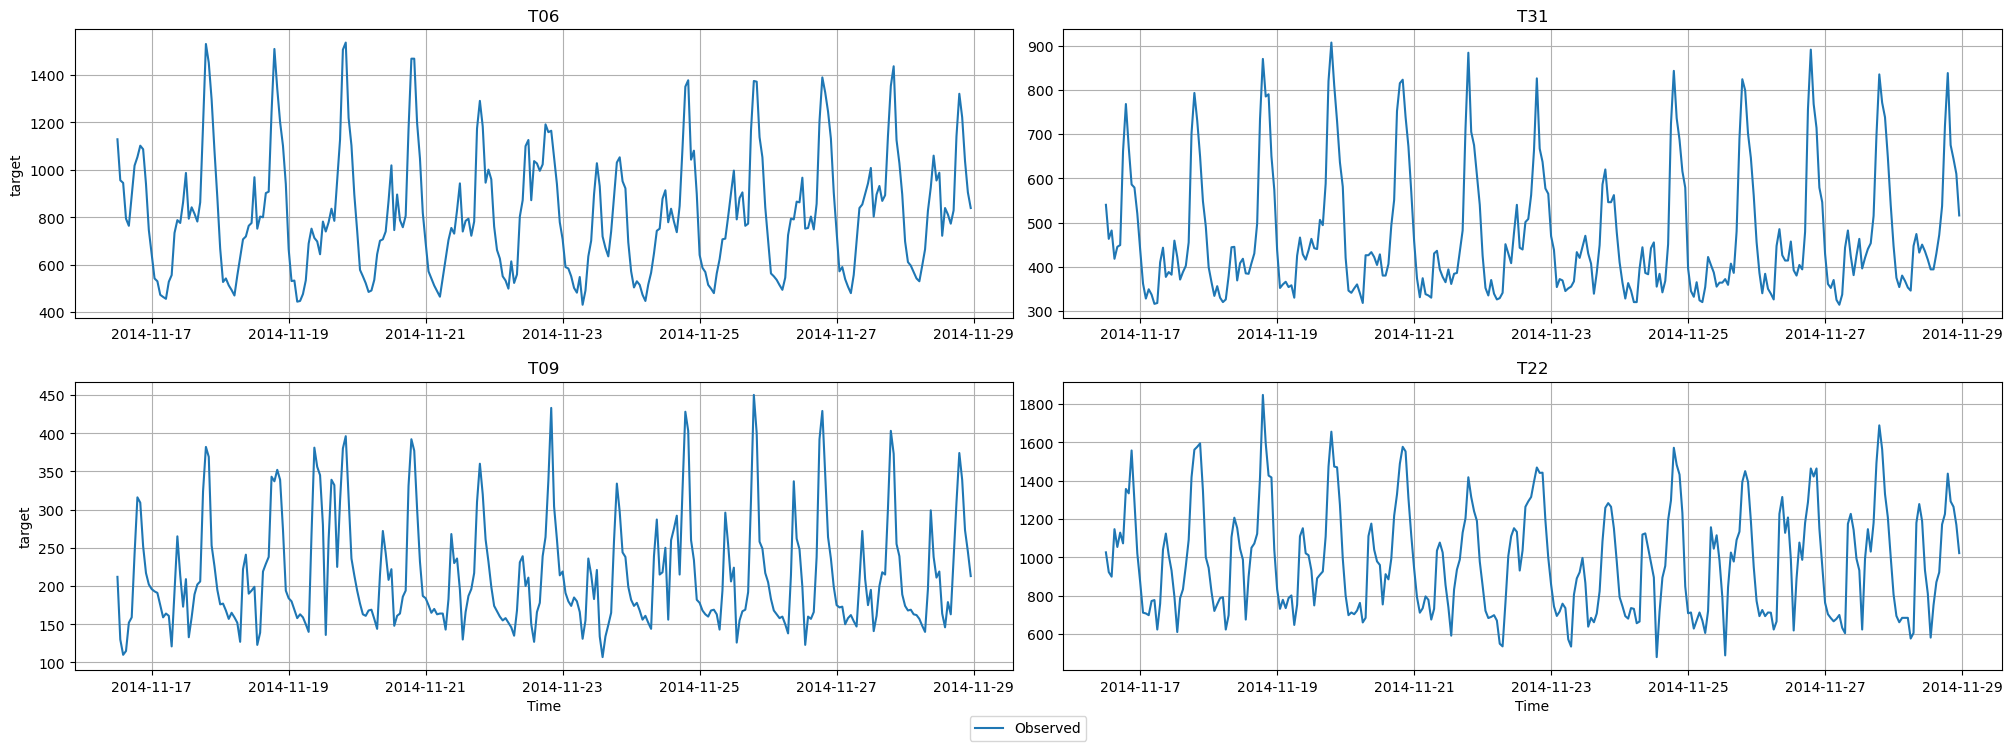

In [6]:
predictor.plot(train_data, max_num_item_ids=4, max_history_length=300)
plt.show()

We see that all time series exhibit a strong _seasonality_. That is, the electricity demand pattern for each day is quite similar to the day before.
A good forecasting model should be able to capture this periodic pattern. We will soon see that AutoGluon can do that quite well.

Many real-world time series datasets exhibit different types of seasonality (e.g., daily or weekly periodicity).
Luckily, as AutoGluon users, we don't need to worry about this - AutoGluon will automatically configure the models to use the correct seasonal period based on the frequency of the data.

Now that we did some very lightweight data exploration, let's train the predictor!

In [7]:
predictor.fit(
    train_data,
    presets="medium_quality",
    time_limit=120,
)

Beginning AutoGluon training... Time limit = 120s
AutoGluon will save models to '/home/ec2-user/SageMaker/awsreinvent2024/Session-OPN302/2024-reinvent/timeseries/autogluon-electricity'
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.10.15
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP Wed Oct 23 17:17:00 UTC 2024
CPU Count:          16
GPU Count:          0
Memory Avail:       57.00 GB / 61.79 GB (92.2%)
Disk Space Avail:   74.18 GB / 78.56 GB (94.4%)
Setting presets to: medium_quality

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': MASE,
 'freq': 'h',
 'hyperparameters': 'light',
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 48,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': False,
 'target': 'target',
 'time_limit': 120,
 'verbosity': 2}



config.json:   0%|          | 0.00/1.12k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/191M [00:00<?, ?B/s]

	-0.6091       = Validation score (-MASE)
	2.81    s     = Training runtime
	5.75    s     = Validation (prediction) runtime
Training timeseries model TemporalFusionTransformer. Training for up to 31.8s of the 63.7s of remaining time.
	-1.1166       = Validation score (-MASE)
	30.03   s     = Training runtime
	0.08    s     = Validation (prediction) runtime
Fitting simple weighted ensemble.
	Ensemble weights: {'Chronos[bolt_small]': 0.63, 'DirectTabular': 0.13, 'ETS': 0.02, 'RecursiveTabular': 0.14, 'SeasonalNaive': 0.06, 'TemporalFusionTransformer': 0.01}
	-0.5964       = Validation score (-MASE)
	0.39    s     = Training runtime
	15.67   s     = Validation (prediction) runtime
Training complete. Models trained: ['Naive', 'SeasonalNaive', 'RecursiveTabular', 'DirectTabular', 'ETS', 'Theta', 'Chronos[bolt_small]', 'TemporalFusionTransformer', 'WeightedEnsemble']
Total runtime: 85.83 s
Best model: WeightedEnsemble
Best model score: -0.5964


Here we used the `"medium_quality"` presets and limited the training time to 2 minutes (120 seconds).

Presets are high-level configuration options that, among other things, define which models AutoGluon will try to fit.
For `medium_quality` presets, these are
- simple baselines (`Naive`, `SeasonalNaive`),
- statistical models (`ETS`, `Theta`),
- tree-based models based on LightGBM (`RecursiveTabular`, `DirectTabular`),
- a deep learning model `TemporalFusionTransformer`,
- a pretrained model `Chronos-Bolt`
- and a weighted ensemble combining these.

Other available presets for `TimeSeriesPredictor` are `"fast_training"`, `"high_quality"` and `"best_quality"`.
Higher quality presets will usually produce more accurate forecasts but take longer to train.

Inside `fit()`, AutoGluon will train as many models as possible within the given time limit.
Trained models are then ranked based on their performance on an internal validation set.
By default, this validation set is constructed by holding out the last `prediction_length` timesteps of each time series in `train_data`.


## Generating forecasts with `TimeSeriesPredictor.predict`

We can now use the fitted `TimeSeriesPredictor` to forecast the future time series values.
By default, AutoGluon will make forecasts using the model that had the best score on the internal validation set.
The forecast always includes predictions for the next `prediction_length` timesteps, starting from the end of each time series in `train_data`.

In [8]:
predictions = predictor.predict(train_data)
predictions.head().round(3)

Model not specified in predict, will default to the model with the best validation score: WeightedEnsemble


mean     0.1     0.2     0.3     0.4     0.5  \
item_id timestamp                                                             
T01     2014-11-29 00:00:00  12.199  10.197  10.916  11.407  11.818  12.199   
        2014-11-29 01:00:00  12.055   9.630  10.504  11.102  11.595  12.055   
        2014-11-29 02:00:00  12.060   9.249  10.267  10.953  11.527  12.060   
        2014-11-29 03:00:00  12.202   9.135  10.223  10.983  11.606  12.202   
        2014-11-29 04:00:00  11.917   8.450   9.684  10.530  11.245  11.917   

                                0.6     0.7     0.8     0.9  
item_id timestamp                                            
T01     2014-11-29 00:00:00  12.573  12.993  13.504  14.270  
        2014-11-29 01:00:00  12.512  13.033  13.648  14.563  
        2014-11-29 02:00:00  12.599  13.195  13.905  14.955  
        2014-11-29 03:00:00  12.807  13.473  14.274  15.450  
        2014-11-29 04:00:00  12.590  13.335  14.232  15.511

AutoGluon produces a _probabilistic_ forecast: in addition to predicting the mean (expected value) of the time series in the future, models also provide the quantiles of the forecast distribution.
The quantile forecasts give us an idea about the range of possible outcomes.
For example, if the `"0.1"` quantile is equal to `500.0`, it means that the model predicts a 10% chance that the target value will be below `500.0`.

We will now visualize the forecast and the actually observed values for one of the time series in the dataset.
We plot the mean forecast, as well as the 10% and 90% quantiles to show the range of potential outcomes.

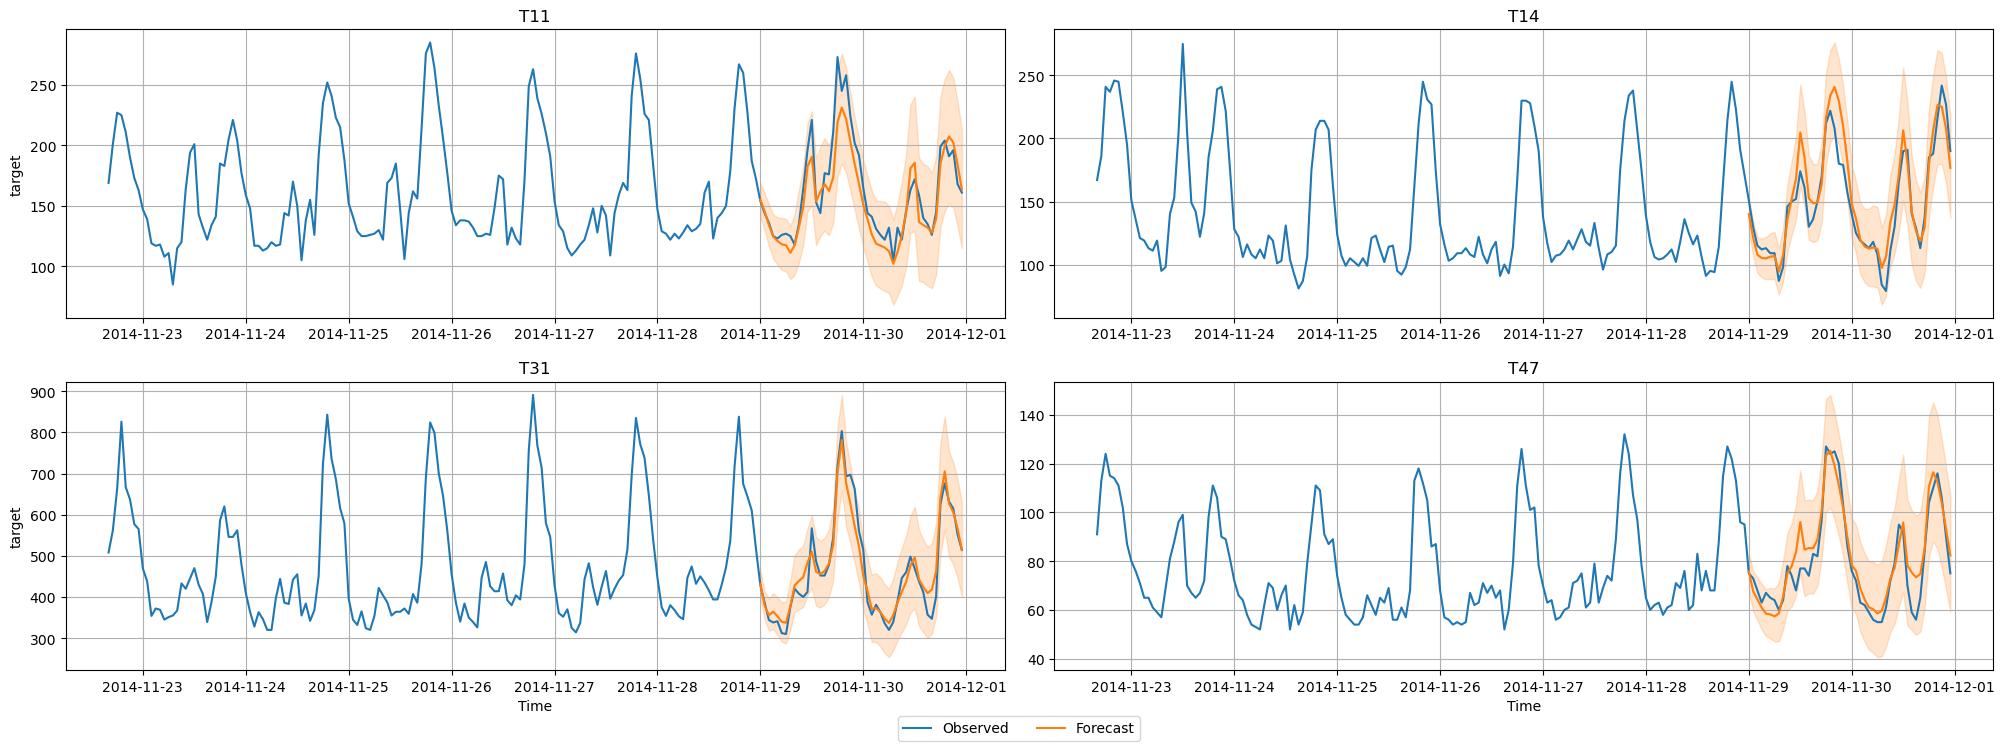

In [9]:
# TimeSeriesDataFrame can also be loaded directly from a file
test_data = TimeSeriesDataFrame.from_path("https://autogluon.s3.us-west-2.amazonaws.com/datasets/timeseries/electricity_small/test.csv")

# Plot 4 randomly chosen time series and the respective forecasts
predictor.plot(test_data, predictions, quantile_levels=[0.1, 0.9], max_history_length=200, max_num_item_ids=4);
plt.show()

## Evaluating the performance of different models

We can view the performance of each model AutoGluon has trained via the `leaderboard()` method.
We provide the test data set to the leaderboard function to see how well our fitted models are doing on the unseen test data.
The leaderboard also includes the validation scores computed on the internal validation dataset.

Note the test data includes both the forecast horizon (last `prediction_length` values of each time series) as well as the historic data (all except the last `prediction_last` values).

In AutoGluon leaderboards, higher scores always correspond to better predictive performance.
Therefore our MASE scores are multiplied by `-1`, such that higher "negative MASE"s correspond to more accurate forecasts.

In [10]:
# The test score is computed using the last
# prediction_length=48 timesteps of each time series in test_data
predictor.leaderboard(test_data)

Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).


,model,score_test,score_val,pred_time_test,pred_time_val,fit_time_marginal,fit_order
0,WeightedEnsemble,-0.692924,-0.596423,8.359627,15.672351,0.388817,9
1,DirectTabular,-0.698948,-0.658358,0.171957,0.167705,1.574541,4
2,Chronos[bolt_small],-0.730283,-0.609118,0.937354,5.751848,2.808824,7
3,RecursiveTabular,-0.842071,-0.667250,2.035607,1.927254,13.102309,3
4,Theta,-1.219124,-0.978284,1.117477,15.839138,0.063404,6
5,ETS,-1.265765,-0.787796,5.015267,7.672338,0.064193,5
6,TemporalFusionTransformer,-1.314861,-1.116573,0.110122,0.083417,30.032775,8
7,SeasonalNaive,-1.487974,-0.758495,0.083764,0.069788,0.062625,2
8,Naive,-2.547722,-2.782406,0.080919,1.135033,0.066184,1


We can also evaluate the performance of the predictor using multiple evaluation metrics with the `evaluate()` method

In [11]:
predictor.evaluate(test_data, metrics=["MASE", "SQL", "RMSE", "MAE"])

Model not specified in predict, will default to the model with the best validation score: WeightedEnsemble


{'MASE': -0.6929240591012759,
 'SQL': -0.632216435469493,
 'RMSE': -75.44277692887728,
 'MAE': -31.215030022589477}

## Recap
We used `autogluon.timeseries` to make probabilistic multi-step forecasts on the electricity load dataset. Here is a compact summary of the steps that we completed:

```python
# 1. Load the data as a TimeSeriesDataFrame
train_data = TimeSeriesDataFrame.from_path("https://autogluon.s3.us-west-2.amazonaws.com/datasets/timeseries/electricity_small/train.csv")

# 2. Define the forecasting task
predictor = TimeSeriesPredictor(prediction_length=48, eval_metric="MASE", target="target")

# 3. Fit the predictor
predictor.fit(train_data, presets="medium_quality", time_limit=120)

# 4. Make predictions
predictions = predictor.predict(train_data)

# 5. (Optional) Evaluate on the test_data
leaderboard = predictor.leaderboard(test_data)
```

## Next steps
Now that we are familiar with the basic functionality AutoGluon-TimeSeries, let's proceed to the next tutorial where will dive into the more advanced features.

Next tutorial: [Forecasting In-depth](02-forecasting-indepth.ipynb).